In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

with open("data/aspartam_similar_CFMID4.0.json", mode = "r") as drugbank:
    db = json.load(drugbank)

2021-12-23 17:34:28.104724: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-23 17:34:28.104759: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tqdm.notebook import tqdm
%matplotlib inline
point_clouds = list()
for m,ms in tqdm(list(db.items())):
    try:
        ms.pop("frag")
    except KeyError:
        pass
    
    sigma = 10
    num = 1000
    max_mass = max([ max( db[m][e]["mz"] ) for e in ms.keys() ])
    min_mass = min([ min( db[m][e]["mz"] ) for e in ms.keys() ])
    x = np.linspace(
        max(min_mass, 0),
        max_mass,
        num = num
    )
    #mixtures = np.zeros((num, len(ms.values() )))
    mixtures = np.zeros((num, 2 ))
    for idx, energy in enumerate(ms.values()):
        if idx == 2:
            continue     
        mix = [
            intens * np.exp(-.5*np.power((x - peak)/sigma,2))
            for peak,intens in zip(energy["mz"], energy["intens"])
        ]
        mix = np.sum(mix, axis = 0)
        mixtures[:,idx] = mix / mix.max()
    point_clouds.append(mixtures)

  0%|          | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


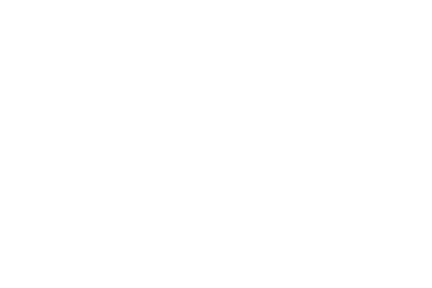

2021-12-23 17:34:30.775519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-23 17:34:30.775586: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-23 17:34:30.775621: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (UX305FA): /proc/driver/nvidia/version does not exist
2021-12-23 17:34:30.776040: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# idea; create a matrix which is the "state" of the complex at some fixed epislon,
# then evolve it using the same principles in markov chain mult.

# 1: represent a filtration step as a markov chain
%matplotlib notebook
fig = plt.figure()
#ax = fig.add_subplot(projection = "3d")
ax = fig.add_subplot()

ms = tf.convert_to_tensor(point_clouds[3], dtype=tf.float32)
#ax.scatter(ms[:,0], ms[:,1], ms[:,2], s = 10, marker = ".")
ax.scatter(ms[:,0], ms[:,1], s = 10, marker = ".")

In [4]:
ms.shape

TensorShape([1000, 2])

<IPython.core.display.Javascript object>


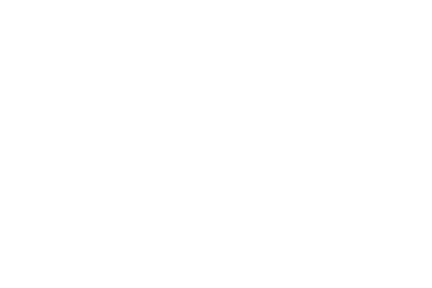

In [5]:
t1 = tf.reshape(ms, (1,ms.shape[0],ms.shape[1]))
t2 = tf.reshape(ms, (ms.shape[0],1,ms.shape[1]))

result = tf.norm(t1-t2, ord='euclidean', axis=2,)

fig = plt.figure()
result = (result < 0.1).numpy()
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        if i == j:
            result[i,j] = False
        
plt.imshow(result)

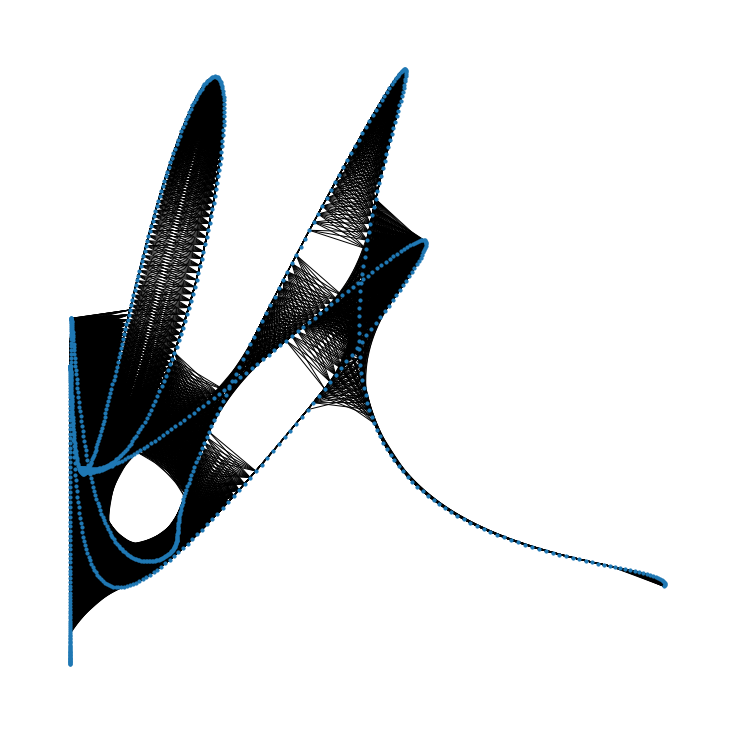

In [6]:
import networkx as nx
%matplotlib inline

G = nx.Graph(result)

fig = plt.figure(figsize=(10,10))
nx.draw(G, pos = { idx : pos for idx,pos in enumerate(ms) }, node_size = 10)